In [1]:
import pandas as pd
import catboost as cb
import plotly.express as px
import matplotlib.pyplot as plt
from DataAnalysis import HelperFunctions as hf
from DataAnalysis import TweakedOvid
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from copy import deepcopy
from catboost import CatBoostClassifier
from sklearn.manifold import TSNE
from tabulate import tabulate
import time, pickle, shap

2023-05-30 14:53:29.848210: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# some general initialization

dataset_path = 'Dataset/'
random_state = 42
shap.initjs()

test_size = 0.2
val_size = 0.1

csdf = pd.read_csv(dataset_path + 'changeset_data.csv').set_index('cs_id')
udf = pd.read_csv(dataset_path + 'user_data.csv').set_index('cs_id').drop(columns='nprev_changesets')
# eldf = pd.read_csv(dataset_path + 'element_data.csv').set_index('cs_id')
labels = pd.read_csv(dataset_path + 'labels.csv').set_index('cs_id')

X, y = hf.get_prepped_csudf(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

features_df = pd.read_csv('/Users/dansvenonius/PycharmProjects/MastersThesis/Dataset/ovid_data.csv').set_index("cs_id")
labels_features = labels.join(features_df, how="left")
y_ovid = labels_features["label"]
X_ovid = labels_features.drop(columns=["label"])
X_train_ovid, X_test_ovid, y_train_ovid, y_test_ovid = train_test_split(X_ovid, y_ovid, test_size=test_size, random_state=random_state)
X_train_ovid, X_val_ovid, y_train_ovid, y_val_ovid = train_test_split(X_train_ovid, y_train_ovid, test_size=val_size/(1-test_size), random_state=random_state)

hyperparameters_mlp = {
    'hidden_layer_sizes': (100, 100),
    'alpha': 1e-05,
    'batch_size': 200,
    'learning_rate_init': 0.001,
    'max_iter': 400
}
hyperparameters_rf = {
    'max_depth': 50,
    'max_features': 5,
    'n_estimators': 500
}
hyperparameters_cb = {
    'depth': 10,
    'iterations': 500,
    'l2_leaf_reg': 0.5
}

In [71]:
with open(dataset_path + 'mlp_shap_values.pkl', 'rb') as f:
    shap_values_mlp = pickle.load(f)
with open(dataset_path + 'rf_shap_values.pkl', 'rb') as f:
    shap_values_rf = pickle.load(f)[1]
with open(dataset_path + 'cb_shap_values.pkl', 'rb') as f:
    shap_values_cb = pickle.load(f)
with open(dataset_path + 'ovid_shap_values.pkl', 'rb') as f:
    shap_values_ovid = pickle.load(f)
editor_app_idx = np.arange(14, 21)

In [110]:
print(f'MLP: {shap_values_mlp.shape}')
print(f'RF: {shap_values_rf.shape}')
print(f'CB: {shap_values_cb.shape}')
print(f'Ovid: {shap_values_ovid.shape}')

MLP: (10365, 30)
RF: (10365, 30)
CB: (10365, 30)
Ovid: (10365, 350)


,create_cs,modify_cs,delete_cs,edits,nnodes,nways,nrelations,min_lon,max_lon,min_lat,...,vespucci,create_u,modify_u,delete_u,contributions,create_nodes,create_ways,create_relations,active_weeks,acc_created
cs_id,,,,,,,,,,,,,,,,,,,,,
15615047,0,923,0,923,0,922,1,-80.729530,-80.342572,43.339653,...,False,10051893,1455609,1115956,12623458,9077969,968032,5892,291,1141783093
132505316,1,1,0,2,2,0,0,-84.509540,-84.509528,42.735685,...,False,395425,107762,67002,570189,329656,65699,70,66,1595685702
130262841,2,0,0,2,2,0,0,-7.931568,-7.631207,40.694799,...,False,362691,119801,83941,566433,318722,42498,1471,343,1284561337
129413667,1,1,0,2,0,2,0,14.210984,14.211361,45.776675,...,False,209884,149088,18309,377281,179927,28581,1376,83,1503127908
127050784,0,6,1,7,6,1,0,-73.100356,-73.093421,44.485479,...,False,167397,98235,84109,349741,155186,12184,27,90,1381499571


In [113]:
sv_summed = [np.zeros((shap_values_cb.shape[0], 30-editor_app_idx.shape[0]+1)) for _ in range(4)]
for sv_sum, sv in zip(sv_summed, [shap_values_mlp, shap_values_rf, shap_values_cb, shap_values_ovid]):
    for i in range(sv_sum.shape[1]):
        if i < editor_app_idx[0]:
            sv_sum[:, i] = sv[:, i]
        elif i > editor_app_idx[0]:
            sv_sum[:, i] = sv[:, i + len(editor_app_idx)-1]
        elif i == editor_app_idx[0]:
            sv_sum[:, i] = np.sum(sv[:, editor_app_idx], axis=1)
sv_summed_mlp, sv_summed_rf, sv_summed_cb, sv_summed_ovid = (sv_summed[i] for i in range(len(sv_summed)))

X_test_summed = X_test.drop(columns=['go map!!','josm','osm go!','other','potlatch','streetcomplete','vespucci'])
X_test_summed = X_test_summed.join(csdf.loc[:, 'editor_app'])
X_test_summed.insert(14, 'editor_app', X_test_summed.pop('editor_app'))

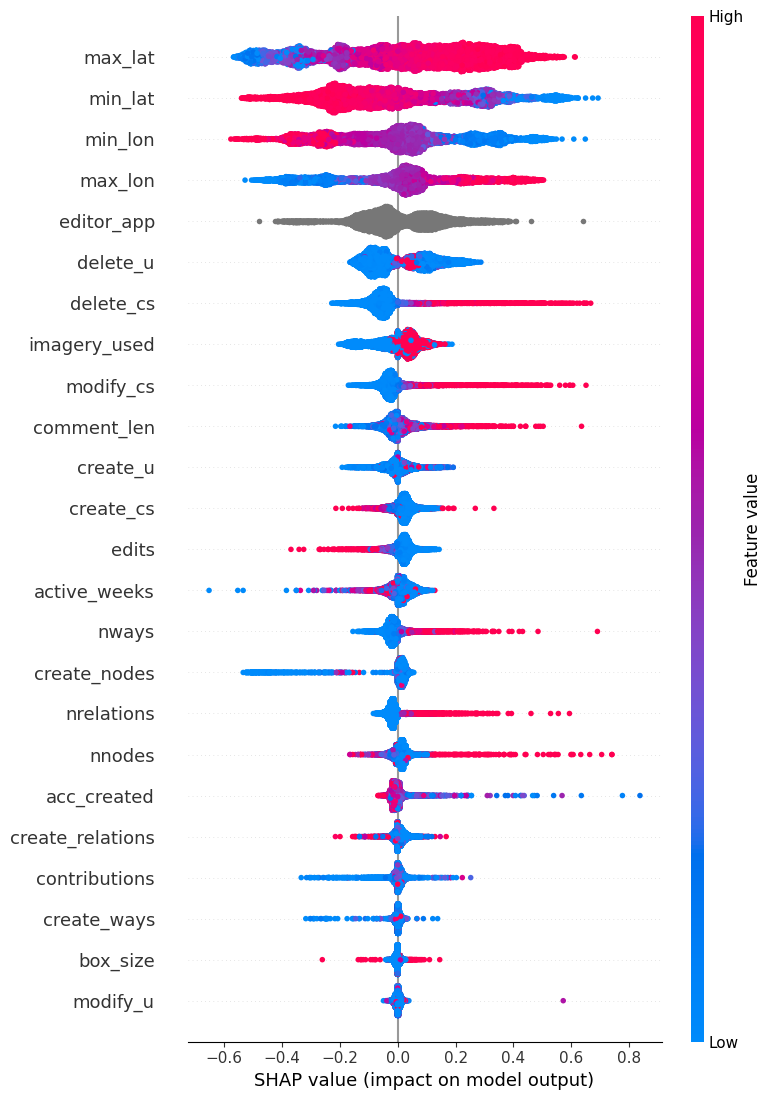

In [92]:
shap.summary_plot(sv_summed_mlp, X_test_summed, max_display=30)
#shap.summary_plot(shap_values_mlp, X_test, max_display=30)

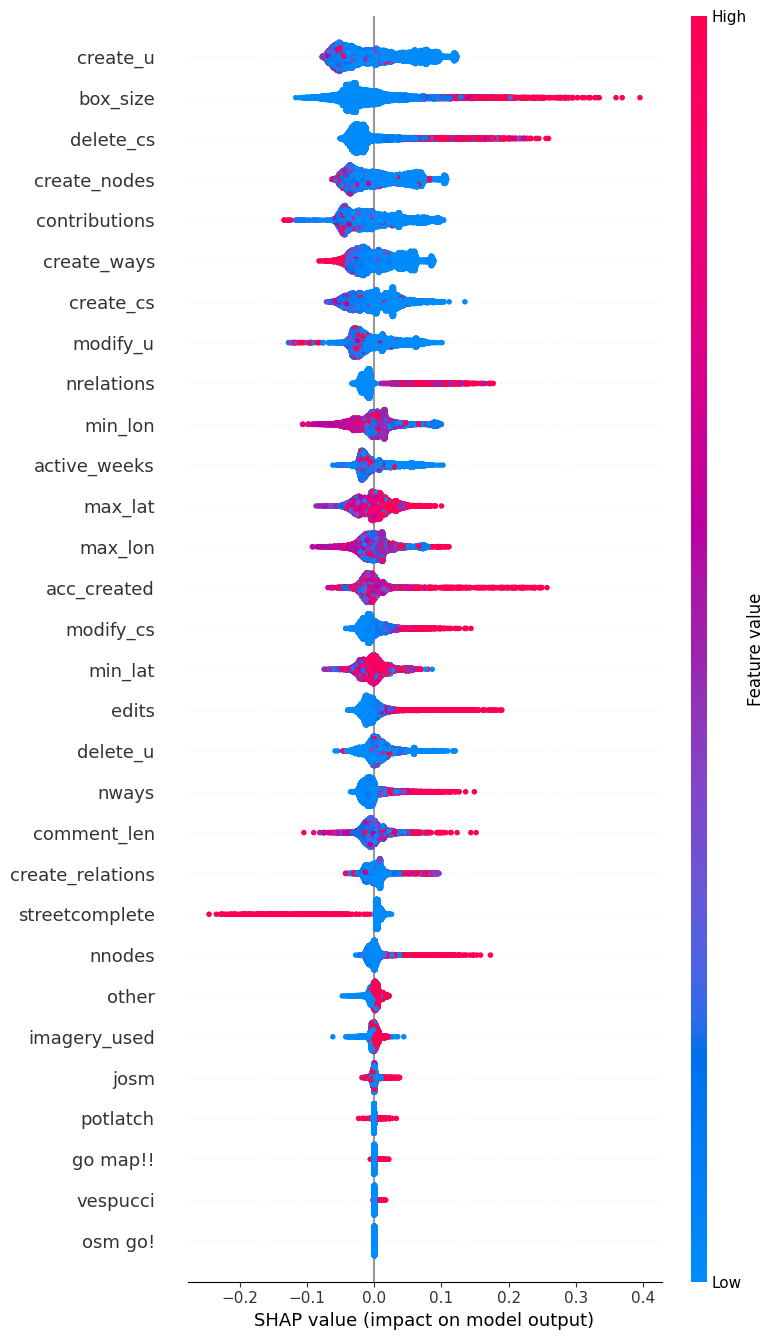

In [96]:
#shap.summary_plot(sv_summed_rf, X_test_summed, max_display=30)
shap.summary_plot(shap_values_rf, X_test, max_display=30)

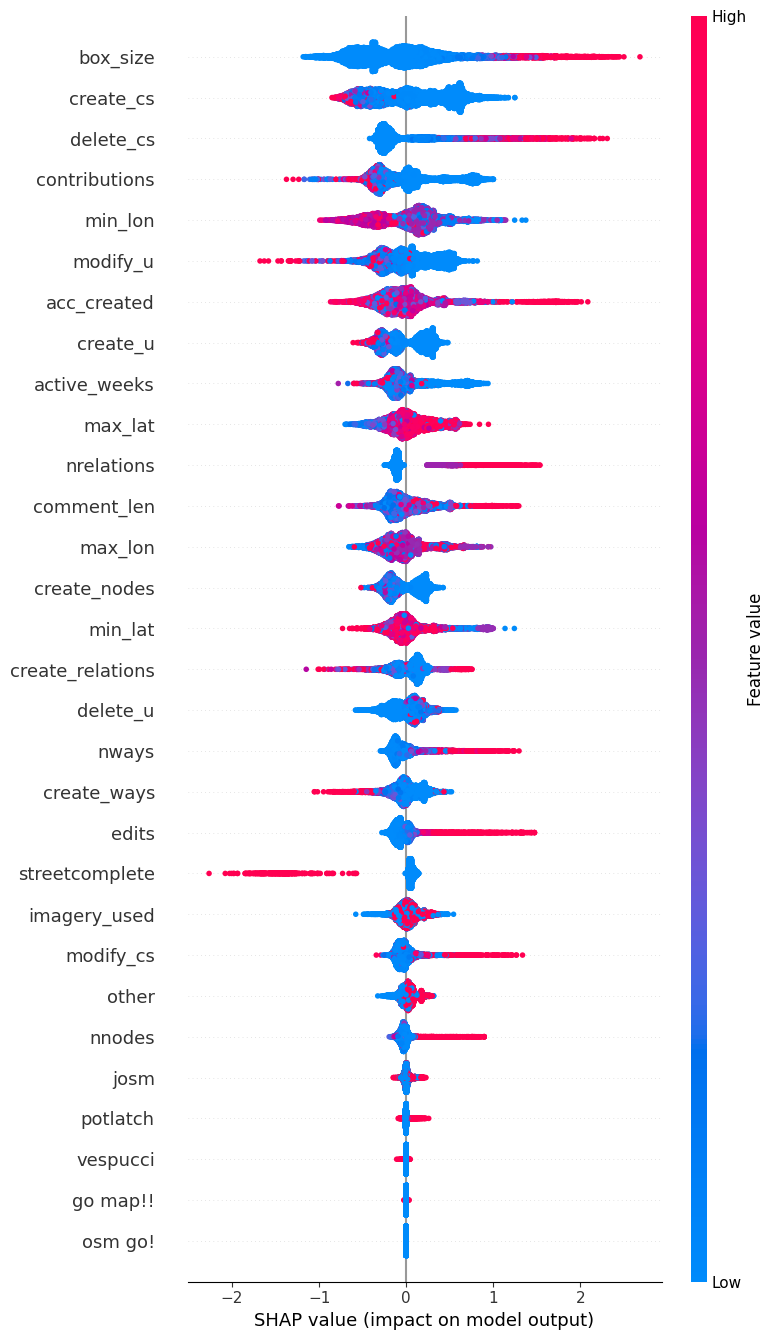

In [115]:
# shap.summary_plot(sv_summed_cb, X_test_summed, max_display=30)
shap.summary_plot(shap_values_cb, X_test, max_display=30)

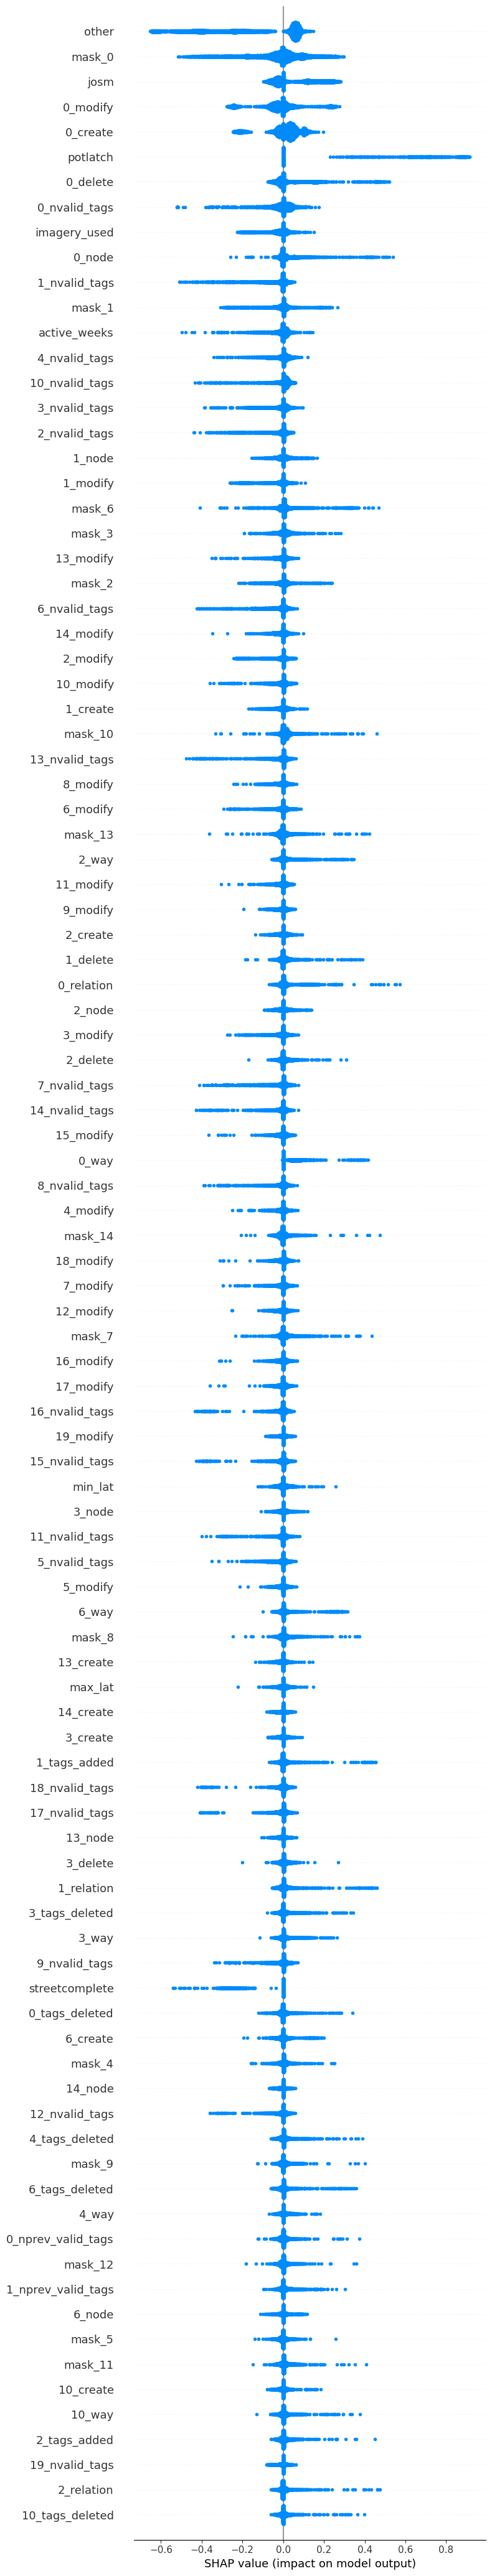

In [8]:
shap.summary_plot(shap_values_ovid, feature_names=X_ovid.columns, max_display=100, color_bar=True)

In [21]:
mlp = MLPClassifier(**hyperparameters_mlp, random_state=random_state)
rf = RandomForestClassifier(**hyperparameters_rf, random_state=random_state)
cb_model = CatBoostClassifier(**hyperparameters_cb, logging_level='Silent', random_state=random_state)
ovid = TweakedOvid.Ovid()

t1 = time.perf_counter()
print("Training MLP")
mlp.fit(X_train_scaled, y_train)
print("Training RF")
rf.fit(X_train, y_train)
print("Training CB")
cb_model.fit(X_train, y_train, verbose=False)
print("Training Ovid")
ovid.fit_scaler(X_train_ovid.to_numpy())
ovid.fit(X_train_ovid.to_numpy(), y_train_ovid.to_numpy(), X_val_ovid.to_numpy(), y_val_ovid.to_numpy())
print(f'Time to train models: {time.perf_counter() - t1}')

Time to train models: 339.3921450880007


In [5]:
user_data_vars = ['create_u', 'modify_u','delete_u','contributions','create_nodes','create_ways','create_relations','active_weeks', 'acc_created']
changeset_data_vars = ['create_cs', 'modify_cs', 'delete_cs', 'edits', 'nnodes', 'nways', 'nrelations', 'min_lon', 'max_lon', 'min_lat', 'max_lat', 'box_size', 'comment_len', 'imagery_used', 'go map!!', 'josm', 'osm go!', 'other', 'potlatch', 'streetcomplete', 'vespucci']

print('80/20 TRAIN/TEST FOR ALL BUT OVID, WHICH IS 70/10/20')
# for keep_var in user_data_vars:
#     drop_vars = deepcopy(user_data_vars)
#     drop_vars.remove(keep_var)
#     print(f'LEAVING OUT ALL BUT: {keep_var}')
for i, drop_vars in enumerate([user_data_vars, changeset_data_vars, []]):

    mlp = MLPClassifier(**hyperparameters_mlp)
    rf = RandomForestClassifier(**hyperparameters_rf)
    cb_model = cb.CatBoostClassifier(**hyperparameters_cb)
    # ovid = TweakedOvid.Ovid(no_user_features=1)
    if i == 0:
        ovid = TweakedOvid.Ovid(no_user_features=0)
        print('------------------------ WITHOUT USER DATA -------------------------')
    elif i == 1:
        ovid = TweakedOvid.Ovid(no_changeset_features=0)
        print('------------------------ WITHOUT CHANGESET DATA -------------------------')
    else:
        ovid = TweakedOvid.Ovid()
        print('------------------------ FULL DATA -------------------------')


    X_reduced = X.drop(columns=drop_vars)

    # 80/20 train/test for MLP
    X_train_80, X_test, y_train_80, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=random_state)
    X_train_80_scaled = scaler.fit_transform(X_train_80)
    X_test_scaled = scaler.transform(X_test)

    # 60/20/20 train/val/test for RF and CB
    # X_train_60, X_val, y_train_60, y_val = train_test_split(X_train_80, y_train_80, test_size=0.25, random_state=random_state)

    features_df = pd.read_csv('/Users/dansvenonius/PycharmProjects/MastersThesis/Dataset/ovid_data.csv').set_index("cs_id")
    labels_features = labels.join(features_df, how="left").reset_index()
    y_ovid = labels_features["label"].to_numpy()
    X_ovid = labels_features.drop(["label", "cs_id"] + drop_vars, axis='columns').to_numpy()

    X_train_ovid, X_test_ovid, y_train_ovid, y_test_ovid = train_test_split(X_ovid, y_ovid, test_size=test_size, random_state=random_state)
    X_train_ovid, X_val_ovid, y_train_ovid, y_val_ovid = train_test_split(X_train_ovid, y_train_ovid, test_size=val_size/(1-test_size), random_state=random_state)
    ovid.fit_scaler(X_train_ovid)

    print('Starting Training\n---------------------------------')
    print('Training MLP')
    mlp.fit(X_train_80_scaled, y_train_80)
    print('Training RF')
    rf.fit(X_train_80, y_train_80)
    print('Training CB')
    cb_model.fit(X_train_80, y_train_80, plot=False, verbose=False)
    print('Training Ovid')
    ovid.fit(X_train_ovid, y_train_ovid, X_val_ovid, y_val_ovid, epochs=100)
    print('Finished Training\n---------------------------------')


    mlp_pred_test = mlp.predict(X_test_scaled)
    rf_pred_test = rf.predict(X_test)
    cb_pred_test = cb_model.predict(X_test) == 'True'
    ovid_pred_test = ovid.predict(X_test_ovid)

    print(f'------------ MLP --------------\n{classification_report(y_test, mlp_pred_test, digits=4)}\n{confusion_matrix(y_test, mlp_pred_test)}')
    print(f'------------ RF --------------\n{classification_report(y_test, rf_pred_test, digits=4)}\n{confusion_matrix(y_test, rf_pred_test)}')
    print(f'------------ CB --------------\n{classification_report(y_test, cb_pred_test, digits=4)}\n{confusion_matrix(y_test, cb_pred_test)}')
    print(f'------------ OVID --------------\n{classification_report(y_test, ovid_pred_test, digits=4)}\n{confusion_matrix(y_test, ovid_pred_test)}')

80/20 TRAIN/TEST FOR ALL BUT OVID, WHICH IS 70/10/20
------------------------ WITHOUT USER DATA -------------------------
Starting Training
---------------------------------
Training MLP
Training RF
Training CB
Training Ovid
Finished Training
---------------------------------
324/324 [==============================] - 1s 2ms/step
------------ MLP --------------
              precision    recall  f1-score   support

       False     0.7870    0.7748    0.7808      5373
        True     0.7616    0.7742    0.7679      4992

    accuracy                         0.7745     10365
   macro avg     0.7743    0.7745    0.7743     10365
weighted avg     0.7747    0.7745    0.7746     10365

[[4163 1210]
 [1127 3865]]
------------ RF --------------
              precision    recall  f1-score   support

       False     0.8316    0.8509    0.8411      5373
        True     0.8354    0.8145    0.8248      4992

    accuracy                         0.8334     10365
   macro avg     0.8335    0.8327

In [9]:
# möjligtvis lättare att bara köra på index rakt av? kan man bara plocka ut rätt rader dirr istället för att bösa med massa olika.

variable = 'active_weeks'
thresholds = [1, 5]
colnames = ['medium_exp', 'big_exp']
X_test_exp = hf.add_experience(deepcopy(X_test), variable, thresholds[0], exp_colname=colnames[0])
X_test_exp = hf.add_experience(X_test_exp, variable, thresholds[1], exp_colname=colnames[1])

exp_idx = [] # from small to big experience
exp_idx.append(X_test.loc[X_test_exp['medium_exp'] == False, :].index)
exp_idx.append(X_test.loc[(X_test_exp['big_exp'] == False) & (X_test_exp['medium_exp'] == True), :].index)
exp_idx.append(X_test.loc[X_test_exp['big_exp'] == True, :].index)

print(f'#low_exp: {len(exp_idx[0])}, #medium_exp: {len(exp_idx[1])}, #big_exp: {len(exp_idx[2])}')


#low_exp: 2512, #medium_exp: 1324, #big_exp: 6529


In [11]:
ovid.fit_scaler(X_train_ovid.to_numpy())
for i, idx in enumerate(exp_idx):
    if i == 0:
        print("------------------------- LOW EXPERIENCE --------------------------")
        print('active_weeks <= 1')
    elif i == 1:
        print("------------------------- MEDIUM EXPERIENCE --------------------------")
        print('active_weeks > 1 && active_weeks <=5')
    else:
        print("------------------------- HIGH EXPERIENCE --------------------------")
        print('active_weeks > 5')
    for j, model in enumerate([mlp, rf, cb_model, ovid]):
        exp_y = y.loc[idx]
        exp_X = X.loc[idx, :]
        if j == 0:
            print("           ------------ MLP ----------------")
            pred = model.predict(scaler.transform(exp_X))
        elif j == 1:
            print("           ------------ RANDOM FOREST ----------------")
            pred = model.predict(exp_X)
        elif j == 2:
            print("           ------------ CATBOOST ----------------")
            pred = model.predict(exp_X) == 'True'
        else:
            print("           ------------ OVID ----------------")
            exp_y = exp_y.to_numpy()
            exp_X = X_ovid.loc[idx, :].to_numpy()
            pred = model.predict(exp_X)
        print(classification_report(exp_y, pred, digits=4))
        print(confusion_matrix(exp_y, pred))

------------------------- LOW EXPERIENCE --------------------------
active_weeks <= 1
           ------------ MLP ----------------
              precision    recall  f1-score   support

       False     0.7740    0.5688    0.6557       596
        True     0.8761    0.9483    0.9108      1916

    accuracy                         0.8583      2512
   macro avg     0.8250    0.7586    0.7832      2512
weighted avg     0.8519    0.8583    0.8503      2512

[[ 339  257]
 [  99 1817]]
           ------------ RANDOM FOREST ----------------
              precision    recall  f1-score   support

       False     0.8851    0.6460    0.7468       596
        True     0.8984    0.9739    0.9346      1916

    accuracy                         0.8961      2512
   macro avg     0.8917    0.8099    0.8407      2512
weighted avg     0.8952    0.8961    0.8901      2512

[[ 385  211]
 [  50 1866]]
           ------------ CATBOOST ----------------
              precision    recall  f1-score   support

 

In [12]:
edit_features = ['edits', 'delete_cs', 'modify_cs','create_cs', 'nnodes', 'nways', 'nrelations', 'box_size']
location_features = ['min_lon', 'max_lon', 'min_lat', 'max_lat']
misc_features = ['comment_len', 'imagery_used', 'go map!!', 'josm', 'osm go!', 'other', 'potlatch', 'streetcomplete', 'vespucci']

cs_features = edit_features + location_features + misc_features
# fixa editor app till de andra

for keep_features in [edit_features, location_features, misc_features]:
    mlp = MLPClassifier(**hyperparameters_mlp)
    rf = RandomForestClassifier(**hyperparameters_rf)
    cb_model = cb.CatBoostClassifier(**hyperparameters_cb, eval_metric='Accuracy', logging_level='Silent')
    ovid = TweakedOvid.Ovid(no_changeset_features=len(keep_features))

    if keep_features == edit_features:
        print('------------------------ WITH EDIT CATEGORY -------------------------')
    elif keep_features == location_features:
        print('------------------------ WITH LOCATION CATEGORY -------------------------')
    elif keep_features == misc_features:
        print('------------------------ WITH MISCELLANEOUS CATEGORY -------------------------')
    print(f'KEPT FEATURES: {keep_features}')

    drop_vars = [feature for feature in cs_features if feature not in keep_features]
    X_reduced = X.drop(columns=drop_vars)

    # 80/20 train/test
    X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=test_size, random_state=random_state)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    # 70/10/20 for Ovid. BORDE VI GÖRA OM DETTA FÖR USER DATA, SOM HAR 60/20/20?
    X_train_ovid, X_test_ovid, y_train_ovid, y_test_ovid = train_test_split(X_ovid.to_numpy(), y_ovid.to_numpy(), test_size=test_size, random_state=random_state)
    X_train_ovid, X_val_ovid, y_train_ovid, y_val_ovid = train_test_split(X_train_ovid, y_train_ovid, test_size=val_size/(1-test_size), random_state=random_state)
    ovid.fit_scaler(X_train_ovid)

    print('Starting Training\n---------------------------------')
    print('Training MLP')
    mlp.fit(X_train_scaled, y_train)
    print('Training RF')
    rf.fit(X_train, y_train)
    print('Training CB')
    cb_model.fit(X_train, y_train, plot=False, verbose=False)
    print('Training Ovid')
    ovid.fit(X_train_ovid, y_train_ovid, X_val_ovid, y_val_ovid, epochs=100)
    print('Finished Training\n---------------------------------')


    mlp_pred_test = mlp.predict(X_test_scaled)
    rf_pred_test = rf.predict(X_test)
    cb_pred_test = cb_model.predict(X_test) == 'True'
    ovid_pred_test = ovid.predict(X_test_ovid)

    print(f'------------ MLP --------------\n{classification_report(y_test, mlp_pred_test, digits=4)}\n{confusion_matrix(y_test, mlp_pred_test)}')
    print(f'------------ RF --------------\n{classification_report(y_test, rf_pred_test, digits=4)}\n{confusion_matrix(y_test, rf_pred_test)}')
    print(f'------------ CB --------------\n{classification_report(y_test, cb_pred_test, digits=4)}\n{confusion_matrix(y_test, cb_pred_test)}')
    print(f'------------ OVID --------------\n{classification_report(y_test, ovid_pred_test, digits=4)}\n{confusion_matrix(y_test, ovid_pred_test)}')

------------------------ WITH EDIT CATEGORY -------------------------
KEPT FEATURES: ['edits', 'delete_cs', 'modify_cs', 'create_cs', 'nnodes', 'nways', 'nrelations', 'box_size']
Starting Training
---------------------------------
Training MLP
Training RF
Training CB
Training Ovid
Finished Training
---------------------------------
324/324 [==============================] - 1s 3ms/step
------------ MLP --------------
              precision    recall  f1-score   support

       False     0.7686    0.8507    0.8076      5373
        True     0.8185    0.7244    0.7685      4992

    accuracy                         0.7899     10365
   macro avg     0.7935    0.7875    0.7881     10365
weighted avg     0.7926    0.7899    0.7888     10365

[[4571  802]
 [1376 3616]]
------------ RF --------------
              precision    recall  f1-score   support

       False     0.8374    0.8673    0.8521      5373
        True     0.8515    0.8187    0.8348      4992

    accuracy                  

In [21]:
acc_exp = np.array([[0.8583, 0.8961, 0.8921, 0.8404],
[0.7946, 0.8625, 0.8512,0.7341],
[0.8236, 0.8727, 0.8703, 0.8081]])



acc_univariate = np.array([[0.8020,0.8644,0.8581,0.7807],
[0.7945,0.8699,0.8581,0.7657],
[0.7852,0.8680,0.8570,0.7483],
[0.8071,0.8663,0.8587,0.7777],
[0.8014,0.8659,0.8562,0.7716],
[0.8032,0.8669,0.8566,0.7719],
[0.7922,0.8528,0.8455,0.7485],
[0.8146,0.8636,0.8517,0.7862],
[0.8028,0.8521,0.8413,0.7727]])

acc_full = np.array(
    [[0.8283, 0.8771, 0.8731, 0.8034],
     [0.8283, 0.8771, 0.8731, 0.8034],
     [0.8283, 0.8771, 0.8731, 0.8034],
     [0.8283, 0.8771, 0.8731, 0.8034],
     [0.8283, 0.8771, 0.8731, 0.8034],
     [0.8283, 0.8771, 0.8731, 0.8034],
     [0.8283, 0.8771, 0.8731, 0.8034],
     [0.8283, 0.8771, 0.8731, 0.8034],
     [0.8283, 0.8771, 0.8731, 0.8034]])





print(np.around(acc_exp/acc_full[:3, :], decimals=4))


print(tabulate(acc_exp/acc_full[:3, :], tablefmt='latex', floatfmt=".4f"))


#print(tabulate(acc_cs_cats/acc_full, tablefmt='latex', floatfmt=".4f"))

[[1.0362 1.0217 1.0218 1.0461]
 [0.9593 0.9834 0.9749 0.9137]
 [0.9943 0.995  0.9968 1.0059]]
\begin{tabular}{rrrr}
\hline
 1.0362 & 1.0217 & 1.0218 & 1.0461 \\
 0.9593 & 0.9834 & 0.9749 & 0.9137 \\
 0.9943 & 0.9950 & 0.9968 & 1.0059 \\
\hline
\end{tabular}


In [78]:
count_el_df = pd.read_csv('/Users/dansvenonius/PycharmProjects/MastersThesis/Dataset/prepped_element_data_counts.csv').set_index('cs_id')
prev_idx = count_el_df.index[0]
count = 0
n_edits = []
for idx, row in count_el_df.iterrows():
    if prev_idx != idx:
        n_edits.append(count)
        prev_idx = idx
        count = 0
    count += row['size']

In [94]:
pdn_edits.quantile(0.60)

20.0

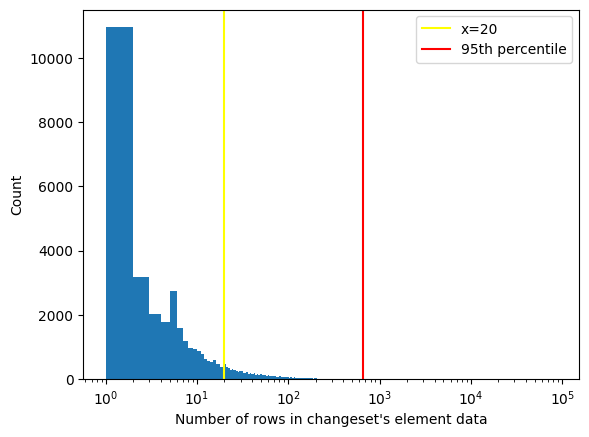

In [95]:
import matplotlib.pyplot as plt
pdn_edits = pd.Series(n_edits)

ax = pdn_edits.plot(kind='hist', logx=True, bins=np.arange(86827))
ax.axvline(20, color='yellow', label='x=20')
ax.axvline(662, color='red', label='95th percentile')
ax.set_ylabel('Count')
ax.set_xlabel("Number of rows in changeset's element data")
ax.legend()

In [10]:
mlp = MLPClassifier(**hyperparameters_mlp)
mlp.fit(X_train_scaled, y_train)
mlp_pred_test = mlp.predict(X_test_scaled)
mlp_pred_train = mlp.predict(X_train_scaled)

In [ ]:
hf.print_report(mlp_pred_train, y_train, mlp_pred_test, y_test, title="MLP Classification")

In [27]:
print(X_test_scaled.shape[0])

10365


In [ ]:
# kör kmeans på 200 datapkter
explainer = shap.KernelExplainer(mlp.predict, shap.kmeans(X_test_scaled, 200))
shap_values = explainer.shap_values(X_test_scaled)#, X_test_scaled.shape[0])
shap.summary_plot(shap_values, feature_names=X_train.columns, max_display=40, color_bar=True)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10365 [00:00<?, ?it/s]

In [16]:
rf = RandomForestClassifier(**hyperparameters_rf)
rf.fit(X_train, y_train)
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

In [ ]:
hf.print_report(rf_pred_train, y_train, rf_pred_test, y_test, title="Random Forest Classification")

In [4]:
shap_rf_test = X_test.reset_index().drop(columns='cs_id')
print(shap_rf_test.columns)
print(list(shap_rf_test.columns))

# right... makes more sense to do editor_app as one variable rather than a one-hot. but one-hot isn't really a problem.
# we can sum, or simpy show every individual category (which could be of interest)

Index(['create_cs', 'modify_cs', 'delete_cs', 'edits', 'nnodes', 'nways',
       'nrelations', 'min_lon', 'max_lon', 'min_lat', 'max_lat', 'box_size',
       'comment_len', 'imagery_used', 'go map!!', 'josm', 'osm go!', 'other',
       'potlatch', 'streetcomplete', 'vespucci', 'create_u', 'modify_u',
       'delete_u', 'contributions', 'create_nodes', 'create_ways',
       'create_relations', 'active_weeks', 'acc_created'],
      dtype='object')
['create_cs', 'modify_cs', 'delete_cs', 'edits', 'nnodes', 'nways', 'nrelations', 'min_lon', 'max_lon', 'min_lat', 'max_lat', 'box_size', 'comment_len', 'imagery_used', 'go map!!', 'josm', 'osm go!', 'other', 'potlatch', 'streetcomplete', 'vespucci', 'create_u', 'modify_u', 'delete_u', 'contributions', 'create_nodes', 'create_ways', 'create_relations', 'active_weeks', 'acc_created']


shapley values calculated
Time: 14210.615368600003


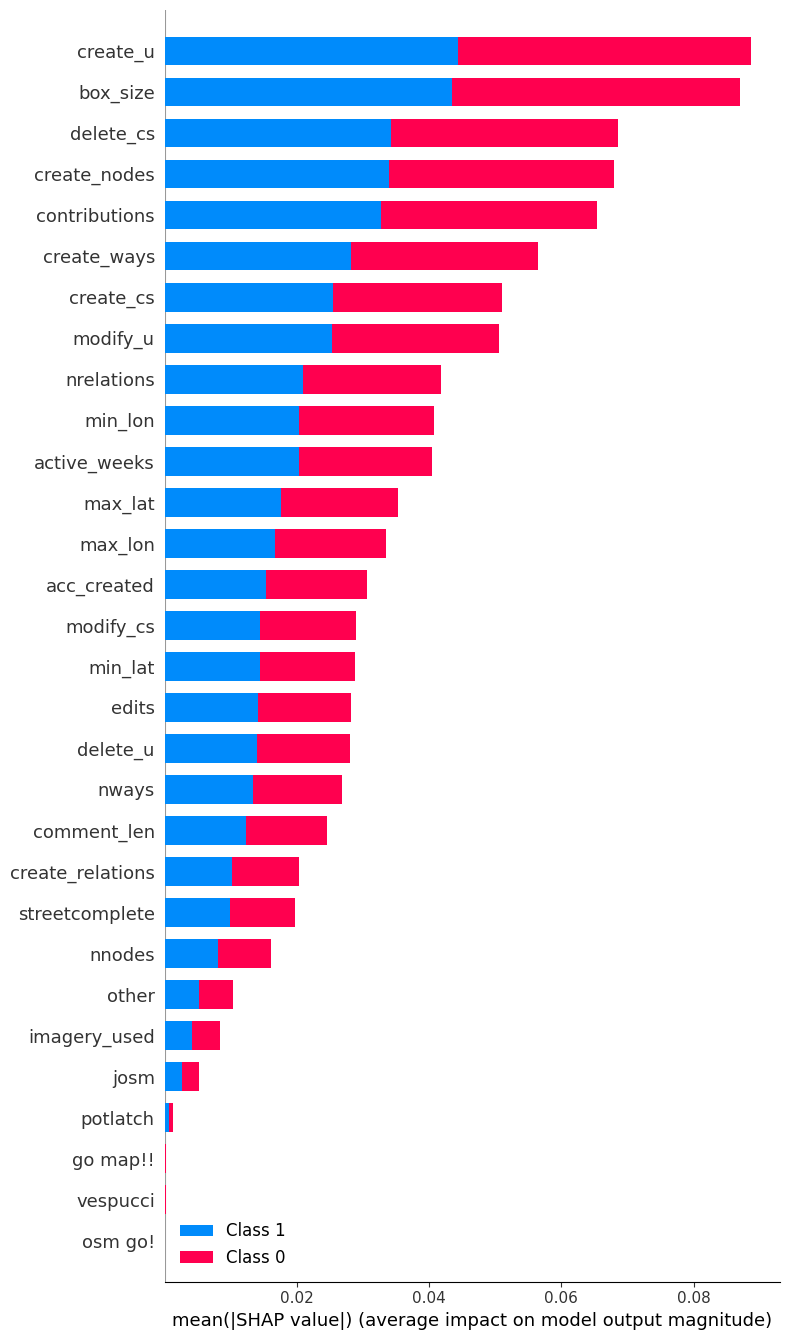

In [17]:
explainer = shap.TreeExplainer(rf)
t1 = time.perf_counter()
shap_values = explainer.shap_values(X_test)
print('shapley values calculated')
print(f'Time: {time.perf_counter() - t1}')
shap.summary_plot(shap_values, X_test, max_display=40)

In [3]:
cb_model = cb.CatBoostClassifier(**hyperparameters_cb, logging_level='Silent')
cb_model.fit(X_train, y_train)

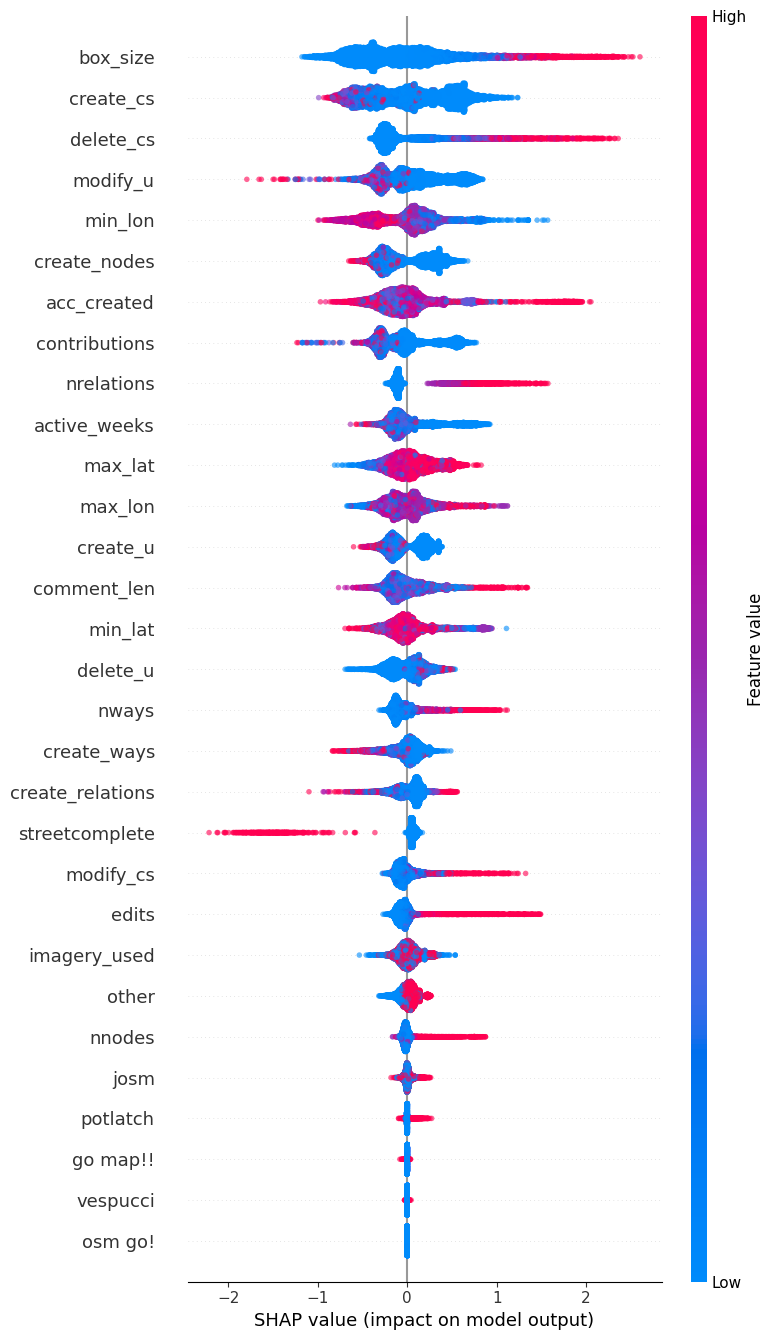

In [7]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=40, alpha=0.6)

In [8]:
ovid = TweakedOvid.Ovid()
ovid.fit_scaler(X_train_ovid)
ovid.fit(X_train_ovid.to_numpy(), y_train_ovid.to_numpy(), X_val_ovid.to_numpy(), y_val_ovid.to_numpy(), epochs=100)

In [ ]:
X_test_ovid_scaled = ovid.transform(X_test_ovid.to_numpy())
explainer = shap.KernelExplainer(ovid.predict, shap.kmeans(X_test_ovid_scaled, 15))
shap_values = explainer.shap_values(X_test_ovid_scaled)
with open(dataset_path + 'ovid_shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)
shap.summary_plot(shap_values, feature_names=X_train.columns, max_display=40, color_bar=True)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


1/1 [==============================] - 0s 24ms/step


  0%|          | 0/10365 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


In [102]:
X_cb, y_cb = hf.get_prepped_csudf(dataset_path)
editor_app_cats = ['go map!!', 'josm', 'osm go!', 'other', 'potlatch', 'streetcomplete', 'vespucci']
X_cb.drop(columns=editor_app_cats, inplace=True)
X_cb = X_cb.join(csdf.loc[:, 'editor_app'])

u_cols = ['create_u', 'modify_u', 'delete_u', 'contributions',
          'create_nodes', 'create_ways', 'create_relations', 'active_weeks']

cols_to_drop = []
cols_to_drop += ['edits', 'delete_cs', 'modify_cs','create_cs', 'nnodes', 'nways', 'nrelations']
cols_to_drop += ['imagery_used', 'editor_app', 'comment_len']
cols_to_drop += ['min_lon', 'max_lon', 'min_lat', 'max_lat', 'box_size']

# X_cb.drop(columns=cols_to_drop + ['create_u' 'modify_u', 'delete_u', 'contributions',
#           'create_nodes', 'create_ways', 'create_relations'], inplace=True)

X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_cb, y_cb, test_size=0.2, random_state=random_state)
# X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(X_train_cb, y_train_cb, test_size=0.125, random_state=random_state)

# drop_jose_nicaragua_train = False
# drop_jose_nicaragua_test = False
# jose_uid = 1104904
# uids = udf.loc[:, 'uid']
# dropped_jose_in_nic_train, dropped_jose_in_nic_val, dropped_jose_in_nic_test = 0, 0, 0
# if drop_jose_nicaragua_train:
#     X_train_cb = X_train_cb.join(uids)
#     X_val_cb = X_val_cb.join(uids)
#     jose_in_nic_train = X_train_cb.loc[(X_train_cb['max_lon'] >= -87.5) & (X_train_cb['max_lon'] <= -82.5) &
#                                         (X_train_cb['max_lat'] >= 11) & (X_train_cb['max_lat'] <= 13) &
#                                         (X_train_cb['uid'] == jose_uid), X_train_cb.columns != 'uid']
#     X_train_cb.drop(index=jose_in_nic_train.index, columns='uid', inplace=True)
#     y_train_cb = y_train_cb.loc[X_train_cb.index]
#     jose_in_nic_val = X_val_cb.loc[(X_val_cb['min_lon'] >= -87.5) & (X_val_cb['max_lon'] <= -82.5) &
#                                     (X_val_cb['min_lat'] >= 11) & (X_val_cb['max_lat'] <= 13) &
#                                     (X_val_cb['uid'] == jose_uid), X_val_cb.columns != 'uid']
#     X_val_cb.drop(index=jose_in_nic_val.index, columns='uid', inplace=True)
#     y_val_cb = y_val_cb.loc[X_val_cb.index]
#     dropped_jose_in_nic_train = len(jose_in_nic_train.index)
#     dropped_jose_in_nic_val = len(jose_in_nic_val.index)
# if drop_jose_nicaragua_test:
#     X_test_cb = X_test_cb.join(uids)
#     jose_in_nic_test = X_test_cb.loc[(X_test_cb['min_lon'] >= -87.5) & (X_test_cb['max_lon'] <= -82.5) &
#                                     (X_test_cb['min_lat'] >= 11) & (X_test_cb['max_lat'] <= 13) &
#                                     (X_test_cb['uid'] == jose_uid), X_test_cb.columns != 'uid']
#     X_test_cb.drop(index=jose_in_nic_test.index, columns='uid', inplace=True)
#     y_test_cb = y_test_cb.loc[X_test_cb.index]
#     dropped_jose_in_nic_test = len(jose_in_nic_test.index)
# if drop_jose_nicaragua_train or drop_jose_nicaragua_test:
#     print(f'Dropped data points from Jose in Nicaragua in...\nTrain: {dropped_jose_in_nic_train}\nVal: {dropped_jose_in_nic_val}\nTest: {dropped_jose_in_nic_test}\n')
# print(f'Number of data points in... \nTrain: {len(X_train_cb.index)}\nValidation: {len(X_val_cb.index)}\nTest: {len(X_test_cb.index)}\nTotal: {len(X_train_cb.index) + len(X_test_cb.index) + len(X_val_cb.index)}\n')
# dropped_cats = ''
# dropped_cats += 'Edit\n' if 'edits' in cols_to_drop else ''
# dropped_cats += 'Miscellaneous\n' if 'imagery_used' in cols_to_drop else ''
# dropped_cats += 'Location\n' if 'box_size' in cols_to_drop else ''
# print(f'Dropped categories:\n{dropped_cats}')

In [103]:
# detta var grid searchen som vi gjorde
# param_grid = {
#     'depth': [4, 7, 10],
#     'l2_leaf_reg': [0.5, 3, 10],
#     'learning_rate': [0.005, 0.03, 0.10]
# }

# detta var hyperparametrarna som kom ut:
hyperparameters_boosted_tree = {
    'depth': 7,
    'learning_rate': 0.1,
    'l2_leaf_reg': 0.5
}

cb_model = cb.CatBoostClassifier(**hyperparameters_cb)
print(X_train_cb.head())

           create_cs  modify_cs  delete_cs  edits  nnodes  nways  nrelations  \
cs_id                                                                          
133016910          0          1          0      1       0      0           1   
82671830           5          4          0      9       1      3           5   
75920732           1          0          0      1       1      0           0   
107915905          0         10          0     10       0     10           0   
64316280          37         25          0     62      56      6           0   

              min_lon     max_lon    min_lat  ...  create_u  modify_u  \
cs_id                                         ...                       
133016910   15.761752   15.786326  50.704988  ...    543714    343541   
82671830   145.767997  145.768752 -38.111416  ...    516343     67833   
75920732   -90.360999  -90.360999  38.520969  ...         0         0   
107915905    9.975898    9.981738  53.559967  ...      7207      5670   
6

In [104]:
if 'editor_app' in X_train_cb.columns:
    cb_model.fit(X_train_cb, y_train_cb, cat_features=['editor_app'])
else:
    cb_model.fit(X_train_cb, y_train_cb, early_stopping_rounds=300, eval_set=[(X_val_cb, y_val_cb)], plot=True)

0:	learn: 0.6787375	total: 63.8ms	remaining: 31.8s
1:	learn: 0.6651735	total: 129ms	remaining: 32.2s
2:	learn: 0.6525238	total: 190ms	remaining: 31.4s
3:	learn: 0.6421224	total: 250ms	remaining: 31s
4:	learn: 0.6317577	total: 310ms	remaining: 30.7s
5:	learn: 0.6215947	total: 388ms	remaining: 31.9s
6:	learn: 0.6120586	total: 464ms	remaining: 32.7s
7:	learn: 0.6018356	total: 532ms	remaining: 32.7s
8:	learn: 0.5939072	total: 604ms	remaining: 33s
9:	learn: 0.5860584	total: 668ms	remaining: 32.7s
10:	learn: 0.5780983	total: 730ms	remaining: 32.5s
11:	learn: 0.5705361	total: 793ms	remaining: 32.2s
12:	learn: 0.5641283	total: 855ms	remaining: 32s
13:	learn: 0.5566769	total: 916ms	remaining: 31.8s
14:	learn: 0.5496213	total: 976ms	remaining: 31.6s
15:	learn: 0.5438792	total: 1.03s	remaining: 31.3s
16:	learn: 0.5378860	total: 1.1s	remaining: 31.2s
17:	learn: 0.5325668	total: 1.16s	remaining: 31s
18:	learn: 0.5270703	total: 1.21s	remaining: 30.8s
19:	learn: 0.5215557	total: 1.27s	remaining: 30.5

In [ ]:
cb_pred_train = cb_model.predict(X_train_cb) == 'True'
cb_pred_test = cb_model.predict(X_test_cb) == 'True'
hf.print_report(cb_pred_train, y_train_cb, cb_pred_test, y_test_cb, title="Boosted Tree Classification", normalize=False, clf_title_test='                  Without category Location')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
##### NICARAGUA CELL #####
jose_uid = 1104904

#X_test_cb = X_test_cb.join(uids)

if 'editor_app' in cols_to_drop:
    cols_to_drop.remove('editor_app')
    cols_to_drop += editor_app_cats
    X_test_nicaragua = X_test_cb.join(X.loc[X_test_cb.index, cols_to_drop])
    cols_to_drop.append('editor_app')
    cols_to_drop = [col for col in cols_to_drop if col not in editor_app_cats]
else:
    X_test_nicaragua = X_test_cb.join(X.loc[X_test_cb.index, cols_to_drop])
X_test_nicaragua, y_test_nicaragua = hf.get_by_coords(dataset_path, X_test_nicaragua, y_test_cb, [-87.5, -82.5], [11, 13])

uids_nicaragua = udf.loc[X_test_nicaragua.index, 'uid']

X_test_jose = X_test_nicaragua.join(uids_nicaragua)
X_test_jose = X_test_jose.loc[X_test_jose['uid'] == jose_uid, X_test_jose.columns != 'uid']
X_test_not_jose = X_test_nicaragua.drop(index=X_test_jose.index)

y_test_jose = y_test_nicaragua.loc[X_test_jose.index]
y_test_not_jose = y_test_nicaragua.loc[X_test_not_jose.index]

preds_nicaragua = np.where(cb_model.predict(X_test_nicaragua) == 'True', True, False)
preds_jose = np.where(cb_model.predict(X_test_jose) == 'True', True, False)
preds_not_jose = np.where(cb_model.predict(X_test_not_jose) == 'True', True, False)

print(f'All of Nicaragua:\n{confusion_matrix(y_test_nicaragua, preds_nicaragua)}')
print(f'Jose in Nicaragua:\n{confusion_matrix(y_test_jose, preds_jose)}')
print(f'Not Jose in Nicaragua:\n{confusion_matrix(y_test_not_jose, preds_not_jose)}')

In [ ]:
fig = px.bar(pd.Series(cb_model.feature_importances_, index=X_cb.columns), title='Internal feature importance')
fig.update_layout(showlegend=False)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, ax = plt.subplots(1, 1, sharey='row')
ax.set_title('Training data')
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test_cb, cb_pred_test, normalize=None), display_labels=['Not Reverted', 'Reverted']).plot(ax=ax, cmap='Greens')
cmd.im_.colorbar.remove()
cmd.ax_.set_xlabel('Predicted label')
cmd.ax_.set_ylabel('True label')
ax.set_title('Test data for Boosted Tree')
plt.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


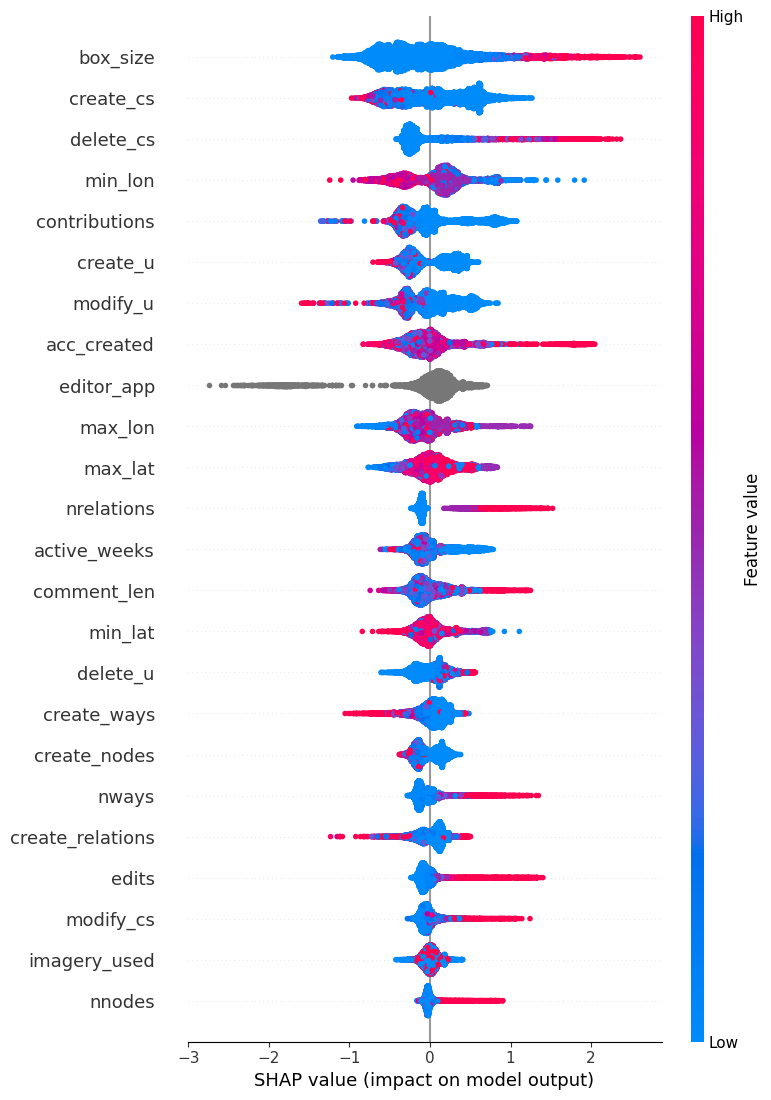

In [105]:
explainer = shap.TreeExplainer(cb_model)
shap_values = explainer.shap_values(X_test_cb)
shap.summary_plot(shap_values, X_test_cb, max_display=30)

In [ ]:
X_test, y_test = hf.get_prepped_csudf(dataset_path)
X_test['comment_len'].corr(X_test['active_weeks'])

In [ ]:
# an interesting finding is that active_weeks is used much less than nprev_changesets, despite removing nprev_cs!
corr = udf['active_weeks'].corr(udf['nprev_changesets'])
print(f'Correlation between active_weeks and nprev_changesets: {corr}')
px.scatter(udf.join(labels), y='active_weeks', x='nprev_changesets', log_x=True, facet_col='label')

In [ ]:
shap.dependence_plot('nprev_changesets', shap_values, X_test, xmin="percentile(0.0)", xmax="percentile(95)", x_jitter=0.5, interaction_index=None)

In [ ]:
original_data = False
my_data = True

# the original model was trained with random_state = 42, so the same will be used below for reproducibility

no_changeset_features = 20 if original_data else 21
ovid = TweakedOvid.Ovid(no_changeset_features=no_changeset_features)

features_df = pd.read_csv('/Users/dansvenonius/PycharmProjects/MastersThesis/Dataset/ovid_data.csv').set_index("cs_id")
if original_data:
    ovid.load("/Users/dansvenonius/PycharmProjects/MastersThesis/models/ovid_model_original_data")
    features_df.drop(columns=['nprev_changesets', 'imagery_used'], inplace=True)
    title = "Ovid Classification, original data"
elif my_data:
    ovid.load("/Users/dansvenonius/PycharmProjects/MastersThesis/models/ovid_model_my_data")
    features_df.drop(columns='acc_created', inplace=True)
    title = "Ovid Classification, my data"

labels_features = labels.join(features_df, how="left").reset_index()
labels_features.fillna(0, inplace=True)

y_ovid = labels_features["label"].to_numpy()
X_ovid = labels_features.drop(["label", "cs_id"], axis='columns').to_numpy()

# 20% test
X_train_ovid, X_test_ovid, y_train_ovid, y_test_ovid = train_test_split(X_ovid, y_ovid, test_size=0.2, random_state=random_state)

# 10% validation, 70% train
X_train_ovid, X_val_ovid, y_train_ovid, y_val_ovid = train_test_split(X_train_ovid, y_train_ovid, test_size=0.125, random_state=random_state)
ovid.fit_scaler(X_train_ovid)

ovid_pred_train = ovid.predict(X_train_ovid)
ovid_pred_test = ovid.predict(X_test_ovid)

hf.print_report(ovid_pred_train, y_train_ovid, ovid_pred_test, y_test_ovid, title=title)

In [ ]:
X, y = hf.get_prepped_csudf(dataset_path)
Xy = y.join(X)
tsne = TSNE()
rev_tsne = tsne.fit_transform(Xy.loc[Xy['label'] == True, Xy.columns!='label'])
rev_tsne = np.hstack((rev_tsne, np.ones((rev_tsne.shape[0], 1), dtype=bool)))
nonrev_tsne = tsne.fit_transform(Xy.loc[Xy['label'] == False, Xy.columns!='label'])
nonrev_tsne = np.hstack((nonrev_tsne, np.zeros((nonrev_tsne.shape[0], 1), dtype=bool)))
tsne_data = np.vstack((rev_tsne, nonrev_tsne))
tsne_df = pd.DataFrame(tsne_data, columns=['tsne_x', 'tsne_y', 'label'])
tsne_df.loc[:, 'label'].replace([0, 1], ['Not reverted', 'Reverted'], inplace=True)
px.scatter(tsne_df, x='tsne_x', y='tsne_y', color='label', width=1000, height=500).show()

In [54]:
multi_file = 'multi_labels_part.csv'
target_names = ['full_revert', 'non_revert', 'partial_revert']
X, y = hf.get_prepped_csudf(dataset_path, multi_label=True, multi_file=multi_file)
y_ovid = pd.get_dummies(y, prefix='', prefix_sep='').replace([0, 1], [False, True])

Xy_ovid = X_ovid.join(y_ovid)
X_ovid, y_ovid = Xy_ovid.drop(columns=target_names), Xy_ovid.loc[:, target_names]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train_ovid, y_test_ovid = train_test_split(y_ovid, test_size=test_size, random_state=random_state)
y_train_ovid, y_val_ovid = train_test_split(y_train_ovid, test_size=val_size/(1-test_size), random_state=random_state)

In [23]:
mlp = MLPClassifier(**hyperparameters_mlp, random_state=random_state)
rf = RandomForestClassifier(**hyperparameters_rf, random_state=random_state)
cb_model = CatBoostClassifier(**hyperparameters_cb, logging_level='Silent', random_state=random_state)
ovid = TweakedOvid.Ovid(binary=False)

t1 = time.perf_counter()
print("Training MLP")
mlp.fit(X_train_scaled, y_train)
print("Training RF")
rf.fit(X_train, y_train)
print("Training CB")
cb_model.fit(X_train, y_train, verbose=False)
print("Training Ovid")
ovid.fit_scaler(X_train_ovid.to_numpy())
ovid.fit(X_train_ovid.to_numpy(), y_train_ovid.to_numpy(), X_val_ovid.to_numpy(), y_val_ovid.to_numpy())
print(f'Time to train models: {time.perf_counter() - t1}')

Training MLP
Training RF
Training CB
Training Ovid
Time to train models: 372.3787280470133


In [44]:
mlp_pred_test = mlp.predict(X_test_scaled)
rf_pred_test = rf.predict(X_test)
cb_pred_test = cb_model.predict(X_test)
ovid_pred_test = ovid.predict(X_test_ovid.to_numpy())

print(f'------------ MLP --------------\n{classification_report(y_test, mlp_pred_test, digits=4, target_names=target_names)}\n{confusion_matrix(y_test, mlp_pred_test)}')
print(f'------------ RF --------------\n{classification_report(y_test, rf_pred_test, digits=4, target_names=target_names)}\n{confusion_matrix(y_test, rf_pred_test)}')
print(f'------------ CB --------------\n{classification_report(y_test, cb_pred_test, digits=4, target_names=target_names)}\n{confusion_matrix(y_test, cb_pred_test)}')
print(f'------------ OVID --------------\n{classification_report(y_test_ovid, ovid_pred_test, digits=4, target_names=target_names)}\n{confusion_matrix(y_test_ovid.to_numpy().argmax(axis=1), ovid_pred_test.argmax(axis=1))}')

324/324 [==============================] - 1s 3ms/step
------------ MLP --------------
                precision    recall  f1-score   support

   full_revert     0.7581    0.8235    0.7894      4600
    non_revert     0.8373    0.8038    0.8202      5373
partial_revert     0.5286    0.2832    0.3688       392

      accuracy                         0.7929     10365
     macro avg     0.7080    0.6368    0.6595     10365
  weighted avg     0.7905    0.7929    0.7895     10365

[[3788  753   59]
 [1014 4319   40]
 [ 195   86  111]]
------------ RF --------------
                precision    recall  f1-score   support

   full_revert     0.8528    0.8450    0.8489      4600
    non_revert     0.8589    0.9135    0.8854      5373
partial_revert     0.8925    0.2117    0.3423       392

      accuracy                         0.8565     10365
     macro avg     0.8681    0.6567    0.6922     10365
  weighted avg     0.8575    0.8565    0.8486     10365

[[3887  703   10]
 [ 465 4908    0]
 

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [68]:
n_samples = y.value_counts().at['partial_revert']
X_full = X.loc[y == 'full_revert'].sample(n_samples, random_state=random_state)
X_non = X.loc[y == 'non_revert'].sample(n_samples, random_state=random_state)
X_part = X.loc[y == 'partial_revert']

Xy = pd.concat([X_full, X_part, X_non]).join(y)
y = Xy.loc[:, 'label']
X = Xy.drop(columns=['label'])

Xy_ovid = pd.concat([X_ovid.loc[X_full.index, :], X_ovid.loc[X_non.index, :], X_ovid.loc[X_part.index, :]]).join(y_ovid)
X_ovid, y_ovid = Xy_ovid.drop(columns=target_names), Xy_ovid.loc[:, target_names]

X_train_ovid, X_test_ovid, y_train_ovid, y_test_ovid = train_test_split(X_ovid, y_ovid, test_size=test_size, random_state=random_state)
X_train_ovid, X_val_ovid, y_train_ovid, y_val_ovid = train_test_split(X_train_ovid, y_train_ovid, test_size=val_size/(1-test_size), random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
y_test_ovid.head()

,full_revert,non_revert,partial_revert
cs_id,,,
56147379,False,False,True
115227985,True,False,False
17812768,False,False,True
99752930,False,False,True
14335046,False,False,True


In [71]:
mlp = MLPClassifier(**hyperparameters_mlp, random_state=random_state)
rf = RandomForestClassifier(**hyperparameters_rf, random_state=random_state)
cb_model = CatBoostClassifier(**hyperparameters_cb, logging_level='Silent', random_state=random_state)
ovid = TweakedOvid.Ovid(binary=False)

t1 = time.perf_counter()
print("Training MLP")
mlp.fit(X_train_scaled, y_train)
print("Training RF")
rf.fit(X_train, y_train)
print("Training CB")
cb_model.fit(X_train, y_train, verbose=False)
print("Training Ovid")
ovid.fit_scaler(X_train_ovid.to_numpy())
ovid.fit(X_train_ovid.to_numpy(), y_train_ovid.to_numpy(), X_val_ovid.to_numpy(), y_val_ovid.to_numpy())
print(f'Time to train models: {time.perf_counter() - t1}')

Training MLP
Training RF
Training CB
Training Ovid
Time to train models: 109.77116245398065


In [72]:
mlp_pred_test = mlp.predict(X_test_scaled)
rf_pred_test = rf.predict(X_test)
cb_pred_test = cb_model.predict(X_test)
ovid_pred_test = ovid.predict(X_test_ovid.to_numpy())

print(f'------------ MLP --------------\n{classification_report(y_test, mlp_pred_test, digits=4, target_names=target_names)}\n{confusion_matrix(y_test, mlp_pred_test)}')
print(f'------------ RF --------------\n{classification_report(y_test, rf_pred_test, digits=4, target_names=target_names)}\n{confusion_matrix(y_test, rf_pred_test)}')
print(f'------------ CB --------------\n{classification_report(y_test, cb_pred_test, digits=4, target_names=target_names)}\n{confusion_matrix(y_test, cb_pred_test)}')
print(f'------------ OVID --------------\n{classification_report(y_test_ovid, ovid_pred_test, digits=4, target_names=target_names)}\n{confusion_matrix(y_test_ovid.to_numpy().argmax(axis=1), ovid_pred_test.argmax(axis=1))}')

38/38 [==============================] - 1s 2ms/step
------------ MLP --------------
                precision    recall  f1-score   support

   full_revert     0.5978    0.6420    0.6191       419
    non_revert     0.6784    0.7153    0.6964       404
partial_revert     0.6484    0.5537    0.5973       363

      accuracy                         0.6400      1186
     macro avg     0.6415    0.6370    0.6376      1186
  weighted avg     0.6407    0.6400    0.6388      1186

[[269  81  69]
 [ 75 289  40]
 [106  56 201]]
------------ RF --------------
                precision    recall  f1-score   support

   full_revert     0.6977    0.5895    0.6391       419
    non_revert     0.7488    0.7896    0.7687       404
partial_revert     0.6749    0.7548    0.7126       363

      accuracy                         0.7083      1186
     macro avg     0.7071    0.7113    0.7068      1186
  weighted avg     0.7081    0.7083    0.7057      1186

[[247  73  99]
 [ 52 319  33]
 [ 55  34 274]]
--

In [ ]:
c1, c2 = 'partial_revert', 'full_revert' # possible values: 'partial_revert', 'full_revert', 'non_revert'
X, y = hf.get_2_of_3_classes(dataset_path, 'partial_revert', 'non_revert', multi_file, to_numpy=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
pred_train, pred_test = rfc.predict(X_train), rfc.predict(X_test)
hf.print_report(pred_train, y_train, pred_test, y_test, [c2, c1], title=f'Random forest, {c1} and {c2}', normalize=False)

In [ ]:
from sklearn.metrics import classification_report

threshold = 1 # quite reasonable that it'd be more than one active week. Cause that takes time into consideration in a way that nrepv_changesets doesnt
exp_metric = 'active_weeks'
# exp_metric = 'nprev_changesets'
labels = pd.read_csv(dataset_path + 'labels.csv').set_index('cs_id')

X, y = hf.get_prepped_csudf(dataset_path)
X['experienced'] = X[exp_metric] > threshold
exp_count = len(X.loc[X['experienced'] == True, :].index)
print(f'Inexperienced: {len(X.index) - exp_count}, experienced: {exp_count}')

X = X.to_numpy()
# exp_idx = np.where(X[:, -1] == True)[0]
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

# The following hyperparameters come from a GridSearchCV.
hyperparameters = {
    'max_depth': 100,
    'max_features': 5,
    'n_estimators': 500
}
rfc = RandomForestClassifier(**hyperparameters)

rfc.fit(X_train[:, :-1], y_train.ravel())
rfc_pred_test = rfc.predict(X_test[:, :-1])
rfc_pred_train = rfc .predict(X_train[:, :-1])
hf.print_report(rfc_pred_train, y_train, rfc_pred_test, y_test, normalize=False)
rfc_experienced_test = rfc.predict(X_test[X_test[:, -1] == True, :-1])
rfc_inexperienced_test = rfc.predict(X_test[X_test[:, -1] == False, :-1])

print("################## EXPERIENCED USERS ##################")
print(classification_report(y_test[X_test[:, -1] == True], rfc_experienced_test))
print("################## INEXPERIENCED USERS ##################")
print(classification_report(y_test[X_test[:, -1] == False], rfc_inexperienced_test))

In [ ]:
# Following a number of data points through the models:
from subprocess import call

id = 13544059
X, y, is_test = hf.get_by_id(dataset_path, id)
X_sample_cb = X_cb.loc[id, :]
X_sample_ovid, _, _ = hf.get_by_id(dataset_path, id, ovid_data=True, original_data=original_data)
X = np.reshape(X, (1, -1))
X_sample_ovid = np.reshape(X_sample_ovid, (1, -1))

mlp_pred = mlp.predict(scaler.transform(X))[0] == 1
rfc_pred = rfc_baseline.predict(X)[0] == 1
cb_pred = cb_model.predict(X_sample_cb)
ovid_pred = ovid.predict(X_sample_ovid)[0]

s1 = 'True = Reverted, False = Not Reverted\n'
s2 = f'In test data: {is_test}, \nGround truth: {y}, \nMLP: {mlp_pred}, \nRF: {rfc_pred}, \nCB: {cb_pred}, \nOvid: {ovid_pred}.'
# cmd = 'echo "%s" | pbcopy' % s2
# call([cmd], shell=True)
print(s1 + s2)

In [ ]:
# px.histogram(plot_csdf, x='create', log_y=True, color="split", barmode="overlay", histnorm="percent",
#              nbins=50, title="Changeset Data", width=600)